**Задание выполнил Артамонов Кирилл, гр. Б01-007.**

In [215]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.axis import YAxis

eps = 1e-9

# Задча __VI..32(Экстраполяция численного значения населения США)__

## 1. Задание данных:

In [216]:
X = [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000] # Years
extrX = 2010
# extendedX = X.append(extrX)
Y = [92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906] # Population
n = len(X)

## 2. Интерполяция методом Ньютона

In [217]:
from os import X_OK
class Interpol:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        assert(len(self.x) == len(self.y))
        
        self.div_difs = np.zeros((len(self.y), len(self.y)))
        self.div_difs[:,0] = self.y

        for i in range(1,len(self.y)):
            for j in range(i,len(self.y)):
                self.div_difs[j][i] = (self.div_difs[j][i-1] - self.div_difs[j-1][i-1])\
                                        / (x[j] - x[j-i])

    # Newthon's polynom value in x0 point
    def calc(self, x0):
        ans = []
        tmp = 1
        ans.append(tmp)
        for i in range(len(self.y)-1):
            '''
            (x-x_0)
            (x-x_0)*(x-x_1)
            ...
            (x-x_0)*...*(x-x_n)
            '''
            tmp *= x0 - self.x[i]
            ans.append(tmp)
            
        # f_0 + (x-x_0)*f_1 + (x-x_0)(x-x_1)*f_2 + ...
        return np.dot(np.array(ans), np.diag(self.div_difs))
    
    def draw_plot(self):
        # plt.figure()
        # extrX = 2010
        # arrX = self.x
        # arrX.append(extrX)
        # arrY = self.y
        # arrY.append([self.calc(extrX)][0])
        plt.figure()
        plt.scatter(self.x, self.y)
        plt.scatter(extrX, [self.calc(2010)][0])
        x = np.linspace(min(self.x), max(self.x) + 11, 100)
        # plt.scatter(extrX, [self.calc(2010)][0])
        plt.plot(x, [self.calc(i) for i in x], 'b--', label='Polynomial Interpolation')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, \
               mode="expand", borderaxespad=0.)
        plt.show()
        print("Extrapolated population in 2010: " , [self.calc(2010)][0])

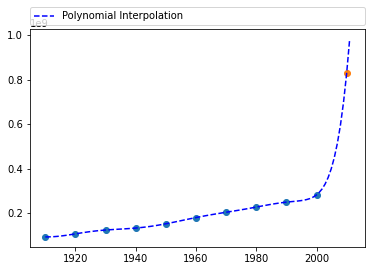

Extrapolated population in 2010:  827906509.0000038


In [218]:
polynom = Interpol(X, Y)
polynom.draw_plot()

Отметим достаточно хорошую интерполяцию, однако экстраполированное значение популяции США в 2010 году составило: __827 906 509__, что очень далеко от действительности. Ошибка экстраполяции огромна.

## 3. Сплайн-интерполяция

In [219]:
class Spline:
    def __init__(self, a = 0, b = 0, c = 0, d = 0, xi = 0):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.xi = xi

    def calc(self, w):
      return self.a  + self.b * (w - self.xi) + self.c * (w - self.xi)**2 + self.d * (w - self.xi)**3         

In [221]:
class Splines:
  def __init__(self, x, f):
    self.x = x
    self.f = f

    # self.N = np.shape(x)[0]
    self.N = n

    self.splines = [Spline(f[i], 0, 0, 0, x[i]) for i in range(self.N)]

  def _calcC(self) -> None:

    alpha = np.full(self.N-1, 0.0)
    beta = np.full(self.N-1, 0.0)

    self.splines[0].c = 0
    self.splines[self.N-1].c = 0

    for i in range(1, self.N-1):
      h_i   = self.x[i] - self.x[i - 1]
      h_i_1 = self.x[i + 1] - self.x[i]

      A_i = h_i
      B_i = 2*(h_i + h_i_1)
      C_i = h_i_1
      F_i = 3.0 * ((self.f[i + 1] - self.f[i]) / h_i_1 - (self.f[i] - self.f[i - 1]) / h_i)

      alpha[i] = -C_i / (A_i * alpha[i - 1] + B_i)
      beta[i] = (F_i - A_i * beta[i-1]) / (A_i * alpha[i - 1] + B_i)
    
    for i in range(self.N - 2, 0, -1):
      self.splines[i].c = alpha[i] * self.splines[i + 1].c + beta[i]


  def _calcB(self) -> None:
    for i in range(self.N - 1, 0, -1):
      hi = self.x[i] - self.x[i - 1]

      self.splines[i].b =  (self.f[i] - self.f[i - 1]) / hi + hi * (2*self.splines[i].c + self.splines[i - 1].c) / 3 
      
  def _calcD(self) -> None:
    for i in range(self.N - 1, 0, -1):
      hi = self.x[i] - self.x[i - 1]

      self.splines[i].d = (self.splines[i].c - self.splines[i - 1].c) / (3*hi)

  def Spline3D(self, interX):

    self._calcC()
    self._calcB()
    self._calcD()

    arrX = np.array([])
    arrY = np.array([])

    for i in range(1, self.N):

      if i == 1:
        x_i_dence = np.linspace(min(interX), self.x[i], self.x[i] - min(interX) + 1)
      elif i == self.N-1:
        x_i_dence = np.linspace(self.x[i-1], max(interX), max(interX) - self.x[i-1] + 1)
      else:
        x_i_dence = np.linspace(self.x[i-1], self.x[i], 50)

      arrX = np.concatenate((arrX, x_i_dence), None)

      y_i_dence = np.array([self.splines[i].calc(x) for x in x_i_dence])
      arrY = np.concatenate((arrY, y_i_dence), None)

    return arrX, arrY

  def draw_plot(self):
    plt.figure()
    plt.scatter(X, Y)
    x, y = splines.Spline3D(np.array(range(1900, 2011)))
    plt.scatter(extrX, y[list(x).index(extrX)])

    plt.plot(x, y, 'b--', label='Spline Interpolation')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, \
            mode="expand", borderaxespad=0.)
    plt.show()
    print("Extrapolated population in 2010: " , y[list(x).index(extrX)])


Построение графика:

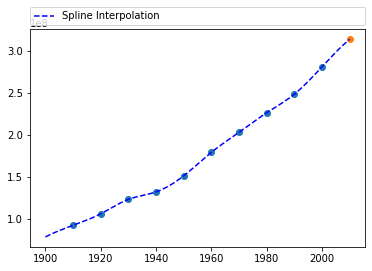

Extrapolated population in 2010:  314133939.0


In [222]:
splines = Splines(X,Y)
splines.draw_plot()

Интерполяци тоже довольно хороша, экстраполированное значение популяции США в 2010 году составило: __314 133 939__, что достаточно близко к реальному значению. Можно сделать вывод, что сплайн-экстраполяция лучше приближает реальное значение, нежели интерполяция полиномами. 